In [1]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Authenticate with Spotify API
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id="dde15d60d0374697803539d92ff4f6fd",
    client_secret="37c92c34cbef42a08d3a8f83f16901a4",
    redirect_uri="http://localhost:9000/callback/",
    scope="user-read-recently-played user-top-read user-library-read user-read-playback-state",
    open_browser=False
))

In [3]:
# 🔹 Step 2: Fetch Recently Played Tracks
results = sp.current_user_recently_played(limit=50)

# 🔹 Step 3: Extract Metadata from Tracks
tracks = []
track_ids = []

for item in results["items"]:
    track = item["track"]
    track_ids.append(track["id"])  # Store track IDs for fetching audio features

    tracks.append({
        "Track Name": track["name"],
        "Artist": track["artists"][0]["name"],
        "Album": track["album"]["name"],
        "Popularity": track["popularity"],  # 0-100 scale
        "Explicit": track["explicit"],  # True/False
        "Duration (min)": track["duration_ms"] / (1000 * 60),  # Convert ms to minutes
        "Played At": item["played_at"]
    })

# Convert to DataFrame
spotify_enriched_df = pd.DataFrame(tracks)

# Convert 'Played At' to datetime format
spotify_enriched_df["Played At"] = pd.to_datetime(spotify_enriched_df["Played At"])

# 🔹 Step 4: Fetch Audio Features in Batches of 50 (to prevent API errors)
import time

# 🔹 Fetch full track details instead of audio features
def get_track_details(track_ids):
    track_data = []
    for i in range(0, len(track_ids), 10):  # Fetch in batches
        batch = track_ids[i:i + 10]
        try:
            tracks = sp.tracks(batch)
            if tracks and "tracks" in tracks:
                track_data.extend(tracks["tracks"])
            time.sleep(0.5)  # Prevent rate limits
        except Exception as e:
            print(f"❌ Error fetching batch {i // 10 + 1}: {e}")
    return track_data

# Fetch track details
track_details = get_track_details(track_ids)

# Convert to DataFrame
track_df = pd.DataFrame(track_details)[["id", "name", "popularity", "explicit"]]

# ✅ Merge with main dataset
spotify_enriched_df = spotify_enriched_df.merge(track_df, left_on="Track Name", right_on="name", how="left")

# Drop unnecessary columns
spotify_enriched_df.drop(columns=["id"], inplace=True)

# Save and display
spotify_enriched_df.to_csv("spotify_track_data.csv", index=False)
print(spotify_enriched_df.head())

                Track Name              Artist  \
0      Koi Kahe Kehta Rahe   Shankar Mahadevan   
1                    Beedi     Sunidhi Chauhan   
2      Jhoom Barabar Jhoom  Shankar-Ehsaan-Loy   
3  Jeene Ke Hain Chaar Din          Sonu Nigam   
4         Jhalak Dikhla Ja   Himesh Reshammiya   

                                         Album  Popularity  Explicit  \
0                               Dil Chahta Hai          56     False   
1  Omkara (Original Motion Picture Soundtrack)          60     False   
2                          Jhoom Barabar Jhoom          53     False   
3                         Mujhse Shaadi Karogi          55     False   
4                                        Aksar          60     False   

   Duration (min)                        Played At                     name  \
0        5.770000 2025-02-21 09:59:16.402000+00:00      Koi Kahe Kehta Rahe   
1        5.836000 2025-02-21 09:53:30.267000+00:00                    Beedi   
2        7.093550 2025-02-21 

In [4]:
spotify_enriched_df.head(10)

,Track Name,Artist,Album,Popularity,Explicit,Duration (min),Played At,name,popularity,explicit
0,Koi Kahe Kehta Rahe,Shankar Mahadevan,Dil Chahta Hai,56,False,5.770000,2025-02-21 09:59:16.402000+00:00,Koi Kahe Kehta Rahe,56,False
1,Beedi,Sunidhi Chauhan,Omkara (Original Motion Picture Soundtrack),60,False,5.836000,2025-02-21 09:53:30.267000+00:00,Beedi,60,False
2,Jhoom Barabar Jhoom,Shankar-Ehsaan-Loy,Jhoom Barabar Jhoom,53,False,7.093550,2025-02-21 09:47:40.064000+00:00,Jhoom Barabar Jhoom,53,False
3,Jeene Ke Hain Chaar Din,Sonu Nigam,Mujhse Shaadi Karogi,55,False,5.355333,2025-02-21 09:40:34.725000+00:00,Jeene Ke Hain Chaar Din,55,False
4,Jhalak Dikhla Ja,Himesh Reshammiya,Aksar,60,False,5.292667,2025-02-21 09:35:13.125000+00:00,Jhalak Dikhla Ja,60,False
5,Kiya Kiya,Anand Raj Anand,Welcome (Original Motion Picture Soundtrack),59,False,5.036833,2025-02-21 09:29:55.541000+00:00,Kiya Kiya,59,False
6,Bhool Bhulaiyaa,Pritam,Bhool Bhulaiyaa,58,False,5.417217,2025-02-21 09:24:53.589000+00:00,Bhool Bhulaiyaa,58,False
7,Zaalim,Badshah,Zaalim,52,False,2.820250,2025-02-21 09:18:07.823000+00:00,Zaalim,52,False
8,Move Your Body Now,Shaan,Kismat Konnection (Original Motion Picture Sou...,39,False,4.110533,2025-02-21 09:15:18.585000+00:00,Move Your Body Now,39,False
9,Jigar Da Tukda,Salim–Sulaiman,Ladies vs Ricky Bahl,47,False,4.241850,2025-02-21 09:11:11.983000+00:00,Jigar Da Tukda,47,False


In [5]:
spotify_palette = ["#1DB954", "#1ed760", "#1aa34a", "#169c45", "#117a37", "#0e5e2d", "#083f1b"]

# Set the color palette globally for Seaborn
sns.set_palette(spotify_palette)

       Popularity  Duration (min)  popularity
count   58.000000       58.000000   58.000000
mean    49.724138        3.737364   49.724138
std      9.365471        1.154368    9.365471
min     21.000000        1.792250   21.000000
25%     44.000000        2.988883   44.000000
50%     51.000000        3.675442   51.000000
75%     57.000000        4.841550   57.000000
max     65.000000        7.093550   65.000000
Unique Tracks: 47
Unique Artists: 34


/var/folders/yb/5k_lxzt100d7tw6hcft3_v9r0000gn/T/ipykernel_78777/3183425649.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette="coolwarm")


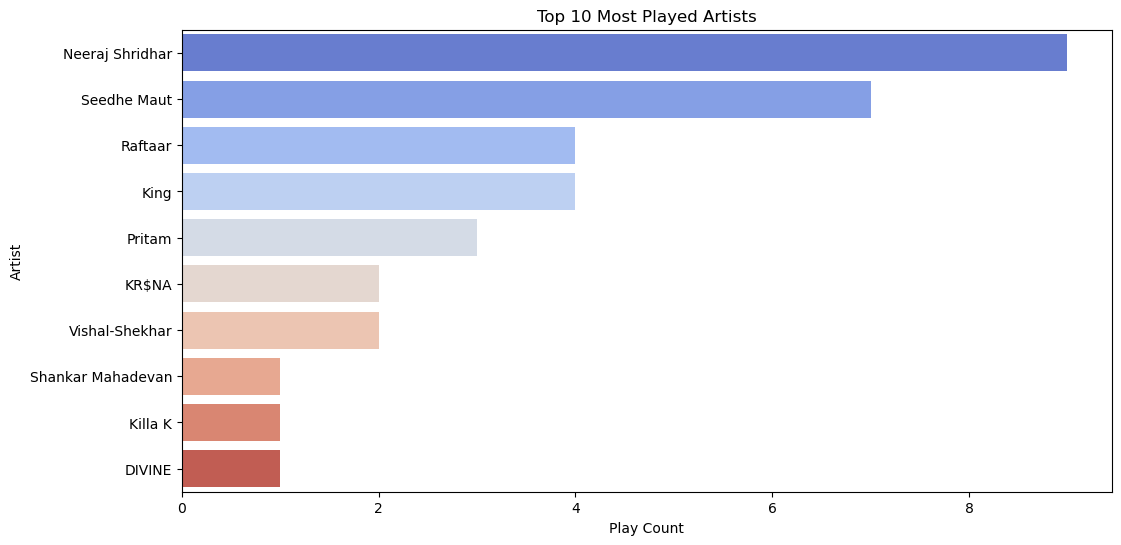

In [6]:
# Summary statistics
print(spotify_enriched_df.describe())

# Count of unique tracks and artists
print(f"Unique Tracks: {spotify_enriched_df['Track Name'].nunique()}")
print(f"Unique Artists: {spotify_enriched_df['Artist'].nunique()}")

# Most played artists
top_artists = spotify_enriched_df["Artist"].value_counts().head(10)

# Plot Top Artists
plt.figure(figsize=(12, 6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette="coolwarm")
plt.title("Top 10 Most Played Artists")
plt.xlabel("Play Count")
plt.ylabel("Artist")
plt.show()

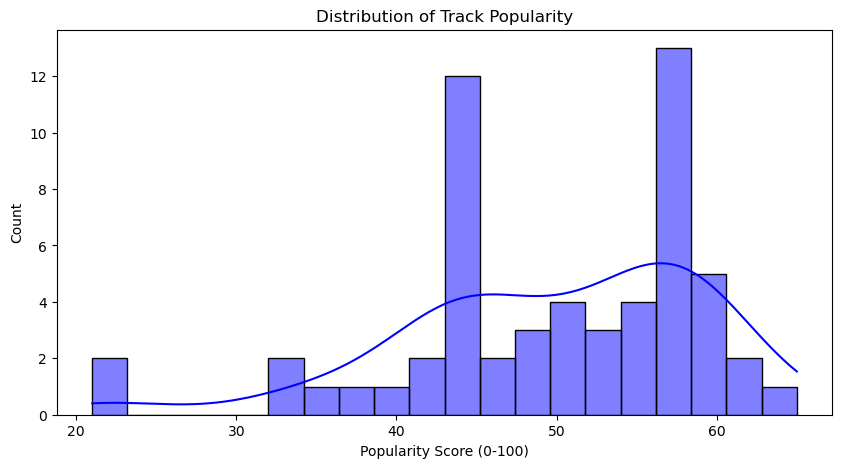

/var/folders/yb/5k_lxzt100d7tw6hcft3_v9r0000gn/T/ipykernel_78777/694335768.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=artist_popularity.values, y=artist_popularity.index, palette="viridis")


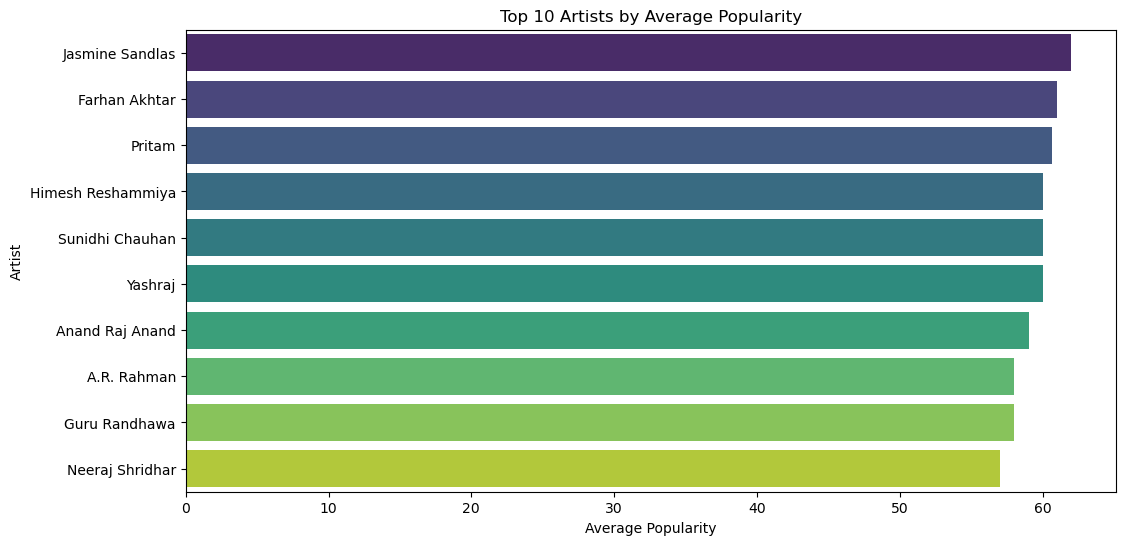

In [7]:
# Popularity Distribution
plt.figure(figsize=(10, 5))
sns.histplot(spotify_enriched_df["Popularity"], bins=20, kde=True, color="blue")
plt.title("Distribution of Track Popularity")
plt.xlabel("Popularity Score (0-100)")
plt.ylabel("Count")
plt.show()

# Average popularity by artist
artist_popularity = spotify_enriched_df.groupby("Artist")["Popularity"].mean().sort_values(ascending=False).head(10)

# Plot Top Popular Artists
plt.figure(figsize=(12, 6))
sns.barplot(x=artist_popularity.values, y=artist_popularity.index, palette="viridis")
plt.title("Top 10 Artists by Average Popularity")
plt.xlabel("Average Popularity")
plt.ylabel("Artist")
plt.show()

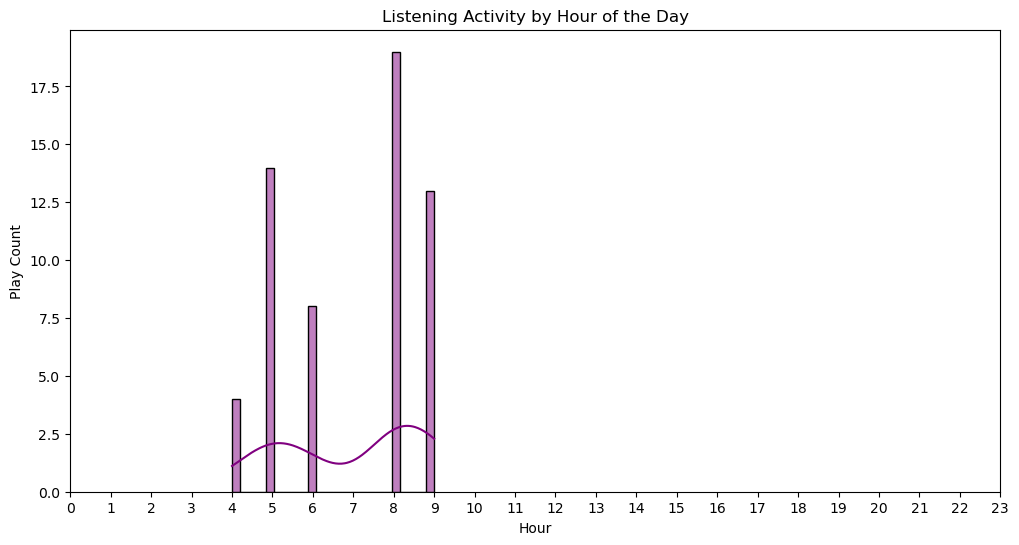

/var/folders/yb/5k_lxzt100d7tw6hcft3_v9r0000gn/T/ipykernel_78777/1300802317.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=spotify_enriched_df, x="Day", palette="pastel", order=day_order)


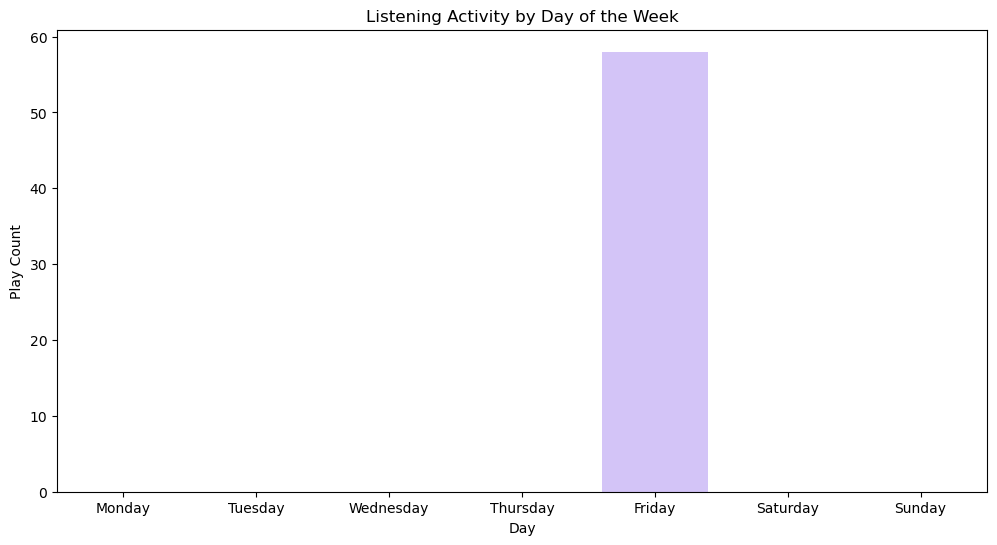

In [8]:
# Extract hour and day of the week
spotify_enriched_df["Hour"] = spotify_enriched_df["Played At"].dt.hour
spotify_enriched_df["Day"] = spotify_enriched_df["Played At"].dt.day_name()

# Hourly listening trend
plt.figure(figsize=(12, 6))
sns.histplot(spotify_enriched_df["Hour"], bins=24, kde=True, color="purple")
plt.title("Listening Activity by Hour of the Day")
plt.xlabel("Hour")
plt.ylabel("Play Count")
plt.xticks(range(24))
plt.show()

# Listening trend by day
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
spotify_enriched_df["Day"] = pd.Categorical(spotify_enriched_df["Day"], categories=day_order, ordered=True)

plt.figure(figsize=(12, 6))
sns.countplot(data=spotify_enriched_df, x="Day", palette="pastel", order=day_order)
plt.title("Listening Activity by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Play Count")
plt.show()

/var/folders/yb/5k_lxzt100d7tw6hcft3_v9r0000gn/T/ipykernel_78777/3526821725.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_tracks.index, x=top_tracks.values, palette="Blues_r")


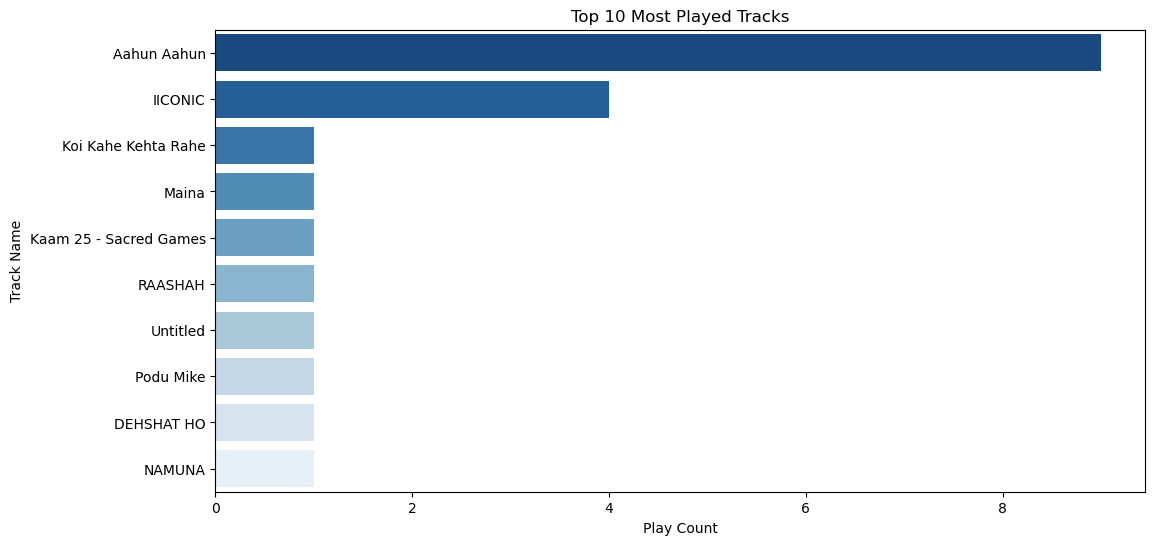

In [9]:
# Top 10 Most Played Tracks
top_tracks = spotify_enriched_df["Track Name"].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(y=top_tracks.index, x=top_tracks.values, palette="Blues_r")
plt.title("Top 10 Most Played Tracks")
plt.xlabel("Play Count")
plt.ylabel("Track Name")
plt.show()